In [171]:
import pandas as pd
import numpy as np
import spacy
from sklearn.preprocessing import LabelBinarizer
import torch
# from transformers import WhisperProcessor, WhisperModel, AutoFeatureExtractor, AutoProcessor, WhisperForConditionalGeneration, WhisperTokenizer
from transformers import AutoModelForCausalLM, AutoTokenizer
from mne_bids import BIDSPath
import mne
from scipy.stats import pearsonr, zscore
from functools import partial

In [295]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
base_path = "/srv/nfs-data/sisko"
bids_root = base_path + "/storage/ECoG_podcast/ds005574-1.0.2" 
context_len = 32
subject = '06'
ecog_sr = 512
ecog_sr_down = 32
whisper_sr = 16000
tmax = 2.0
pre_stimulus = 2.0
pre_audio = 0.2
func = partial(zscore) 


In [229]:
# model_w = WhisperModel.from_pretrained("openai/whisper-base")
# feature_extractor = AutoFeatureExtractor.from_pretrained("openai/whisper-base")
# tokenizer_w = WhisperTokenizer.from_pretrained("openai/whisper-base")
# processor_w = AutoProcessor.from_pretrained("openai/whisper-base")
# model_w.eval()

from transformers import GPT2TokenizerFast, GPT2Model, AutoTokenizer, AutoModelForCausalLM

model_name = "gpt2"
tokenizer_gpt = AutoTokenizer.from_pretrained(model_name)
tokenizer_gpt.pad_token = tokenizer_gpt.eos_token
model_gpt = AutoModelForCausalLM.from_pretrained(model_name)
model_gpt.eval()
model_gpt.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

## From Paper

In [174]:
transcript_path = f"{bids_root}/stimuli/podcast_transcript.csv"
df = pd.read_csv(transcript_path)
df.head(10)

,word,start,end
0,Act,3.710,3.790
1,"one,",3.990,4.190
2,monkey,4.651,4.931
3,in,4.951,5.011
4,the,5.051,5.111
5,middle.,5.151,5.391
6,So,6.592,6.732
7,there's,6.752,6.912
8,some,6.892,7.052
9,places,7.072,7.342


In [175]:
# !python -m spacy download en_core_web_sm

In [176]:
modelname = "en_core_web_sm"
nlp = spacy.load(modelname)

In [177]:
df.insert(0, "word_idx", df.index.values)
df["word_with_ws"] = df.word.astype(str) + " "
df["hftoken"] = df.word_with_ws.apply(nlp.tokenizer)
df = df.explode("hftoken", ignore_index=True)
df.head(10)

,word_idx,word,start,end,word_with_ws,hftoken
0,0,Act,3.710,3.790,Act,Act
1,1,"one,",3.990,4.190,"one,",one
2,1,"one,",3.990,4.190,"one,",","
3,2,monkey,4.651,4.931,monkey,monkey
4,3,in,4.951,5.011,in,in
5,4,the,5.051,5.111,the,the
6,5,middle.,5.151,5.391,middle.,middle
7,5,middle.,5.151,5.391,middle.,.
8,6,So,6.592,6.732,So,So
9,7,there's,6.752,6.912,there's,there


In [178]:
words = [token.text for token in df.hftoken.tolist()]
spaces = [token.whitespace_ == " " for token in df.hftoken.tolist()]
doc = spacy.tokens.Doc(nlp.vocab, words=words, spaces=spaces)
doc = nlp(doc)

In [179]:
features = []
for token in doc:
    features.append([token.text, token.tag_, token.dep_, token.is_stop])

df2 = pd.DataFrame(
        features, columns=["token", "pos", "dep", "stop"], index=df.index
    )
df = pd.concat([df, df2], axis=1)
df.drop(["hftoken", "word_with_ws"], axis=1, inplace=True)
df.head(10)

,word_idx,word,start,end,token,pos,dep,stop
0,0,Act,3.710,3.790,Act,NNP,ROOT,False
1,1,"one,",3.990,4.190,one,CD,nummod,True
2,1,"one,",3.990,4.190,",",",",punct,False
3,2,monkey,4.651,4.931,monkey,NN,appos,False
4,3,in,4.951,5.011,in,IN,prep,True
5,4,the,5.051,5.111,the,DT,det,True
6,5,middle.,5.151,5.391,middle,NN,pobj,False
7,5,middle.,5.151,5.391,.,.,punct,False
8,6,So,6.592,6.732,So,RB,advmod,True
9,7,there's,6.752,6.912,there,EX,expl,True


In [180]:
taggerEncoder = LabelBinarizer().fit(nlp.get_pipe("tagger").labels)
dependencyEncoder = LabelBinarizer().fit(nlp.get_pipe("parser").labels)

a = taggerEncoder.transform(df.pos.tolist())
b = dependencyEncoder.transform(df.dep.tolist())
c = LabelBinarizer().fit_transform(df.stop.tolist())
embeddings = np.hstack((a, b, c))
print(f"Embeddings have a shape of: {embeddings.shape}")

Embeddings have a shape of: (5305, 96)


In [181]:
df["hftoken"] = df.word.apply(lambda x: tokenizer_gpt.tokenize(" " + x))

df = df.explode("hftoken", ignore_index=True)
df["token_id"] = df.hftoken.apply(tokenizer_gpt.convert_tokens_to_ids)

df.head(10)

,word_idx,word,start,end,token,pos,dep,stop,hftoken,token_id
0,0,Act,3.710,3.790,Act,NNP,ROOT,False,ĠAct,2191
1,1,"one,",3.990,4.190,one,CD,nummod,True,Ġone,530
2,1,"one,",3.990,4.190,one,CD,nummod,True,",",11
3,1,"one,",3.990,4.190,",",",",punct,False,Ġone,530
4,1,"one,",3.990,4.190,",",",",punct,False,",",11
5,2,monkey,4.651,4.931,monkey,NN,appos,False,Ġmonkey,21657
6,3,in,4.951,5.011,in,IN,prep,True,Ġin,287
7,4,the,5.051,5.111,the,DT,det,True,Ġthe,262
8,5,middle.,5.151,5.391,middle,NN,pobj,False,Ġmiddle,3504
9,5,middle.,5.151,5.391,middle,NN,pobj,False,.,13


In [182]:
token_ids = df.token_id.tolist()
fill_value = 0
if tokenizer_gpt.pad_token_id is not None:
    fill_value = tokenizer_gpt.pad_token_id

data = torch.full((len(token_ids), context_len + 1), fill_value, dtype=torch.long)
for i in range(len(token_ids)):
    example_tokens = token_ids[max(0, i - context_len) : i + 1]
    data[i, -len(example_tokens) :] = torch.tensor(example_tokens)

print(f"Data has a shape of: {data.shape}")

Data has a shape of: torch.Size([5827, 33])


In [183]:
batch_size = 32
data_dl = torch.utils.data.DataLoader(
        data, batch_size=batch_size, shuffle=False
        )

In [184]:
import tqdm

embeddings = []

with torch.no_grad():
    for batch in tqdm.tqdm(data_dl):
        # Get output from model
        output = model_gpt(batch.to(device), output_hidden_states=True)
        # logits = output.logits
        states = output.hidden_states

        true_ids = batch[:, -1]
        brange = list(range(len(true_ids)))
        # logits_order = logits[:, -2, :].argsort(descending=True)
        # batch_top_guesses = logits_order[:, 0]
        # batch_ranks = torch.eq(logits_order, true_ids.reshape(-1, 1).to(device)).nonzero()[:, 1]
        # batch_probs = torch.softmax(logits[:, -2, :], dim=-1)
        # batch_true_probs = batch_probs[brange, true_ids]
        # batch_entropy = torch.distributions.Categorical(probs=batch_probs).entropy()
        batch_embeddings = [state.numpy(force=True) for state in states]

        embeddings.append(batch_embeddings)

100%|██████████| 183/183 [00:05<00:00, 33.96it/s]


In [185]:
print(f"There are {len(embeddings[0])} layers of embeddings")
print(f"Each Batch embedding is {embeddings[0][0].shape} dimensions long")

There are 13 layers of embeddings
Each Batch embedding is (32, 33, 768) dimensions long


In [187]:
layer_index = -1

all_embeddings = np.concatenate(
    [batch[layer_index] for batch in embeddings],  # ogni elemento ha shape (batch_size, 33, 768)
    axis=0  
)

print(all_embeddings.shape)

(5827, 33, 768)


In [188]:
transcript_path = f"{bids_root}/stimuli/gpt2-xl/transcript.tsv"
df_contextual = pd.read_csv(transcript_path, sep="\t", index_col=0)
if "rank" in df_contextual.columns:
    model_acc = (df_contextual["rank"] == 0).mean()
    print(f"Model accuracy: {model_acc*100:.3f}%")

df_contextual.head()

Model accuracy: 30.942%


,word_idx,word,start,end,hftoken,token_id,rank,true_prob,top_pred,entropy
0,0,Act,3.710,3.790,ĠAct,2191,1644,0.000012,0,2.402717
1,1,"one,",3.990,4.190,Ġone,530,92,0.000342,352,3.732053
2,1,"one,",3.990,4.190,",",11,3,0.059520,25,4.259335
3,2,monkey,4.651,4.931,Ġmonkey,21657,4022,0.000018,3715,6.621269
4,3,in,4.951,5.011,Ġin,287,15,0.004237,0,4.444838


In [189]:
aligned_embeddings = []
for _, group in df_contextual.groupby("word_idx"): # group by word index
    indices = group.index.to_numpy()
    average_emb = all_embeddings[indices].mean(0)
    aligned_embeddings.append(average_emb)
aligned_embeddings = np.stack(aligned_embeddings)
print(f"LLM embeddings matrix has shape: {aligned_embeddings.shape}")

LLM embeddings matrix has shape: (5136, 33, 768)


In [190]:
df_word = df_contextual.groupby("word_idx").agg(dict(word="first", start="first", end="last"))
df_word.head()

,word,start,end
word_idx,,,
0,Act,3.710,3.790
1,"one,",3.990,4.190
2,monkey,4.651,4.931
3,in,4.951,5.011
4,the,5.051,5.111


In [ ]:
df_word.to_csv("/srv/nfs-data/sisko/matteoc/podcast/df_word.csv", index=False)
torch.save(torch.tensor(aligned_embeddings), "/srv/nfs-data/sisko/matteoc/podcast/text_embeds_gpt.pt")

## Start from Here

In [296]:
file_path = BIDSPath(root=bids_root+"/derivatives/ecogprep",
                     subject=subject,
                     task="podcast",
                     datatype="ieeg",
                     description="highgamma",
                     suffix="ieeg",
                     extension="fif")


transcript_path = f"{bids_root}/stimuli/podcast_transcript.csv"

df = pd.read_csv(transcript_path)
df.dropna(subset=['start'], inplace=True)
df.sort_values("start", inplace=True)
events = np.zeros((len(df), 3))
events[:, 0] = df.start

In [297]:
from torch.nn.utils.rnn import pad_sequence
import tqdm

download_text = True

def get_text_and_brain(file_path, df, tmax=2.0, pre_audio=2.0, pre_stimulus=2.0,
                          model=None, tokenizer=None,
                          device=device, context_len=32):
    
    model = model.to(device)

    raw = mne.io.read_raw_fif(file_path, verbose=False)
    raw.load_data()
    raw = raw.apply_function(func, channel_wise=True, verbose=False)

    events = np.zeros((len(df), 3), dtype=int)
    events[:, 0] = (df.start * raw.info['sfreq']).astype(int)

    epochs = mne.Epochs(
        raw,
        events,
        tmin=-pre_stimulus,
        tmax=tmax,
        baseline=None,
        proj=False,
        event_id=None,
        preload=True,
        event_repeated="merge",
        verbose=False
    )
    good_idx = epochs.selection
    print(f"Epochs object has a shape of: {epochs._data.shape}")
    epochs = epochs.resample(sfreq=ecog_sr_down, npad='auto', method='fft', window='hamming')
    epochs_snippet = epochs._data
    print(f"Epochs object after down-sampling has a shape of: {epochs_snippet.shape}")

    if download_text:
        text_decoder_embd = []

        for row_idx in tqdm.tqdm(good_idx):
            
            row = df.iloc[row_idx]
            word_list = df[
                (df["start"] >= row["start"] - pre_audio) & 
                (df["end"] <= row["start"] + 0.6)
            ]
            words_in_segment = word_list["word"].tolist()
            transcription = " ".join(words_in_segment)

            # row = df.iloc[row_idx]
            # current_idx = row.name  
            # start_idx = max(0, current_idx - context_len)
            # end_idx = min(len(df), current_idx + 1)  
            # words_in_context = df.iloc[start_idx:end_idx]["word"].tolist()
            # transcription_context = " ".join(words_in_context)

            with torch.no_grad():    
                # -------- GPT
                inputs = tokenizer(transcription, return_tensors="pt")
                input_ids = inputs["input_ids"].to(device)
                attention_mask = inputs["attention_mask"].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
                last_hidden_dec = outputs.hidden_states[-1]
                last_hidden_dec = last_hidden_dec.squeeze(0)
                text_decoder_embd.append(last_hidden_dec.cpu())
        
        text_decoder_embd = pad_sequence(text_decoder_embd, batch_first=True, padding_side='left')
        # text_decoder_embd = text_decoder_embd[:, -6:, :]         # TODO: 18
        # text_decoder_embd = torch.stack(text_decoder_embd, dim=0) 
        # torch.save(text_decoder_embd, f"{base_path}/matteoc/podcast/text_2_2_sec.pt")

    else:
        # text_decoder_embd = torch.load(f"{base_path}/matteoc/podcast/text_embeds_gpt.pt")
        text_decoder_embd = aligned_embeddings[good_idx]

    print(f"Text snippets after processing have a shape of: {text_decoder_embd.shape}")

    return epochs_snippet, text_decoder_embd

In [298]:
df_word = pd.read_csv("/srv/nfs-data/sisko/matteoc/podcast/df_word.csv")
brain_data, text_decoder_embd = get_text_and_brain(file_path, df=df_word, tmax=tmax, model=model_gpt,
                                                      tokenizer=tokenizer_gpt, pre_stimulus=pre_stimulus, 
                                                      pre_audio=2.0)

Reading 0 ... 921599  =      0.000 ...  1799.998 secs...


/tmp/ipykernel_1960828/1235946832.py:19: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(


Epochs object has a shape of: (5130, 166, 2049)
Epochs object after down-sampling has a shape of: (5130, 166, 128)


100%|██████████| 5130/5130 [00:19<00:00, 258.86it/s]


Text snippets after processing have a shape of: torch.Size([5130, 24, 768])


In [299]:
brain_timep = brain_data.shape[-1]
brain_channels = brain_data.shape[1]
audio_timep = text_decoder_embd.shape[1]
text_feature = text_decoder_embd.shape[-1]

In [300]:
from torch.utils.data import TensorDataset, DataLoader, Subset
from sklearn.preprocessing import StandardScaler
import torch

n = brain_data.shape[0]
train_size = int(0.8 * n)
val_size = int(0.1 * n)
test_size = n - train_size - val_size

indices = list(range(n))
train_idx = indices[:train_size]
val_idx   = indices[train_size:train_size+val_size]
test_idx  = indices[train_size+val_size:]

brain_train_std = torch.tensor(brain_data[train_idx], dtype=torch.float32)
brain_val_std   = torch.tensor(brain_data[val_idx],   dtype=torch.float32)
brain_test_std  = torch.tensor(brain_data[test_idx],  dtype=torch.float32)

stimuli = torch.tensor(text_decoder_embd).to(torch.float32)
stimuli_train = stimuli[train_idx]
stimuli_val   = stimuli[val_idx]
stimuli_test  = stimuli[test_idx]

train_ds = TensorDataset(stimuli_train, brain_train_std)
val_ds   = TensorDataset(stimuli_val, brain_val_std)
test_ds  = TensorDataset(stimuli_test, brain_test_std)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


/tmp/ipykernel_1960828/4186908696.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stimuli = torch.tensor(text_decoder_embd).to(torch.float32)


In [301]:
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # se usi GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [302]:
from torch import nn, optim
from tqdm import tqdm
from models import AttentiveStim2BrainNet, LearnableTau, SoftMappingGRUSeq
import torch.nn.functional as F

set_seed(42)
# model = SoftMappingGRUSeq(input_dim=text_feature, hidden_dim=256, time_out=brain_timep, output_channels=brain_channels).to(device)
model = AttentiveStim2BrainNet(input_dim=text_feature, output_channels=brain_channels, time_in=audio_timep, time_out=brain_timep, d_model=256).to(device)
mse_loss = nn.MSELoss()
tau_module = LearnableTau(init_tau=0.03).to(device) # 0.03

mse_perc = 0.0
cl_perc = 1.0

def pearson_loss(pred, target, eps=1e-8):
    pred = pred - pred.mean(dim=-1, keepdim=True)
    target = target - target.mean(dim=-1, keepdim=True)
    corr_num = (pred * target).sum(dim=-1)
    corr_den = (pred.norm(dim=-1) * target.norm(dim=-1)).clamp(min=eps)
    corr = corr_num / corr_den
    return 1 - corr.mean()

def contrastive_loss(pred, target, tau=0.02):
    target = target.reshape(target.shape[0], -1)
    pred = pred.reshape(pred.shape[0], -1)   
    pred = F.normalize(pred, dim=1)   # (batch, 1)
    target = F.normalize(target, dim=1)
    sim_matrix = torch.mm(pred, target.T)   # (batch, batch)
    sim_matrix = sim_matrix / tau
    loss = -torch.log(torch.exp(torch.diag(sim_matrix)) / sim_matrix.exp().sum(dim=1))
    return loss.mean()

optimizer = optim.AdamW(list(model.parameters()) + list(tau_module.parameters()), lr=1e-4, betas=(0.9, 0.99), weight_decay=1e-3)   # 1e-4
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)

# Training loop
num_epochs = 35
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        y_pred, _ = model(x)
        loss = mse_perc * mse_loss(y_pred, y) + cl_perc * contrastive_loss(y_pred, y, tau=tau_module())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)

    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            y_pred, _ = model(x)
            loss = mse_perc * mse_loss(y_pred, y) + cl_perc * contrastive_loss(y_pred, y, tau=tau_module())
            val_loss += loss.item() * x.size(0)
    val_loss /= len(val_loader.dataset)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Salva il modello migliore
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "/home/matteoc/ecog-speech/best_model_CL2.pt")


Epoch 1/35: 100%|██████████| 129/129 [00:01<00:00, 78.90it/s]


Epoch 1, Train Loss: 3.5226, Val Loss: 3.5006


Epoch 2/35: 100%|██████████| 129/129 [00:01<00:00, 77.49it/s]


Epoch 2, Train Loss: 3.4827, Val Loss: 3.4712


Epoch 3/35: 100%|██████████| 129/129 [00:01<00:00, 77.58it/s]


Epoch 3, Train Loss: 3.4693, Val Loss: 3.4766


Epoch 4/35: 100%|██████████| 129/129 [00:01<00:00, 77.72it/s]


Epoch 4, Train Loss: 3.4222, Val Loss: 3.4326


Epoch 5/35: 100%|██████████| 129/129 [00:01<00:00, 77.60it/s]


Epoch 5, Train Loss: 3.3746, Val Loss: 3.4182


Epoch 6/35: 100%|██████████| 129/129 [00:01<00:00, 77.62it/s]


Epoch 6, Train Loss: 3.3212, Val Loss: 3.4161


Epoch 7/35: 100%|██████████| 129/129 [00:01<00:00, 77.69it/s]


Epoch 7, Train Loss: 3.2658, Val Loss: 3.3876


Epoch 8/35: 100%|██████████| 129/129 [00:01<00:00, 77.42it/s]


Epoch 8, Train Loss: 3.1919, Val Loss: 3.3278


Epoch 9/35: 100%|██████████| 129/129 [00:01<00:00, 77.66it/s]


Epoch 9, Train Loss: 3.0891, Val Loss: 3.2925


Epoch 10/35: 100%|██████████| 129/129 [00:01<00:00, 77.12it/s]


Epoch 10, Train Loss: 2.9452, Val Loss: 3.2198


Epoch 11/35: 100%|██████████| 129/129 [00:01<00:00, 77.20it/s]


Epoch 11, Train Loss: 2.7733, Val Loss: 3.1394


Epoch 12/35: 100%|██████████| 129/129 [00:01<00:00, 77.76it/s]


Epoch 12, Train Loss: 2.6015, Val Loss: 3.1288


Epoch 13/35: 100%|██████████| 129/129 [00:01<00:00, 77.24it/s]


Epoch 13, Train Loss: 2.4525, Val Loss: 3.1052


Epoch 14/35: 100%|██████████| 129/129 [00:01<00:00, 77.51it/s]


Epoch 14, Train Loss: 2.3264, Val Loss: 3.0549


Epoch 15/35: 100%|██████████| 129/129 [00:01<00:00, 77.34it/s]


Epoch 15, Train Loss: 2.1936, Val Loss: 3.0529


Epoch 16/35: 100%|██████████| 129/129 [00:01<00:00, 77.73it/s]


Epoch 16, Train Loss: 2.0819, Val Loss: 3.0266


Epoch 17/35: 100%|██████████| 129/129 [00:01<00:00, 77.23it/s]


Epoch 17, Train Loss: 1.9623, Val Loss: 3.0386


Epoch 18/35: 100%|██████████| 129/129 [00:01<00:00, 78.28it/s]


Epoch 18, Train Loss: 1.8613, Val Loss: 3.0614


Epoch 19/35: 100%|██████████| 129/129 [00:01<00:00, 78.27it/s]


Epoch 19, Train Loss: 1.7716, Val Loss: 3.0732


Epoch 20/35: 100%|██████████| 129/129 [00:01<00:00, 77.63it/s]


Epoch 20, Train Loss: 1.6779, Val Loss: 3.1217


Epoch 21/35: 100%|██████████| 129/129 [00:01<00:00, 77.64it/s]


Epoch 21, Train Loss: 1.6354, Val Loss: 3.1486


Epoch 22/35: 100%|██████████| 129/129 [00:01<00:00, 77.89it/s]


Epoch 22, Train Loss: 1.5462, Val Loss: 3.1646


Epoch 23/35: 100%|██████████| 129/129 [00:01<00:00, 77.67it/s]


Epoch 23, Train Loss: 1.4544, Val Loss: 3.1036


Epoch 24/35: 100%|██████████| 129/129 [00:01<00:00, 78.16it/s]


Epoch 24, Train Loss: 1.3915, Val Loss: 3.0949


Epoch 25/35: 100%|██████████| 129/129 [00:01<00:00, 77.63it/s]


Epoch 25, Train Loss: 1.3651, Val Loss: 3.1047


Epoch 26/35: 100%|██████████| 129/129 [00:01<00:00, 76.39it/s]


Epoch 26, Train Loss: 1.3499, Val Loss: 3.1069


Epoch 27/35: 100%|██████████| 129/129 [00:01<00:00, 77.80it/s]


Epoch 27, Train Loss: 1.3316, Val Loss: 3.1126


Epoch 28/35: 100%|██████████| 129/129 [00:01<00:00, 77.98it/s]


Epoch 28, Train Loss: 1.3126, Val Loss: 3.1180


Epoch 29/35: 100%|██████████| 129/129 [00:01<00:00, 77.75it/s]


Epoch 29, Train Loss: 1.2946, Val Loss: 3.1075


Epoch 30/35: 100%|██████████| 129/129 [00:01<00:00, 78.09it/s]


Epoch 30, Train Loss: 1.2869, Val Loss: 3.1112


Epoch 31/35: 100%|██████████| 129/129 [00:01<00:00, 78.25it/s]


Epoch 31, Train Loss: 1.2794, Val Loss: 3.1152


Epoch 32/35: 100%|██████████| 129/129 [00:01<00:00, 77.88it/s]


Epoch 32, Train Loss: 1.2761, Val Loss: 3.1162


Epoch 33/35: 100%|██████████| 129/129 [00:01<00:00, 77.57it/s]


Epoch 33, Train Loss: 1.2771, Val Loss: 3.1193


Epoch 34/35: 100%|██████████| 129/129 [00:01<00:00, 77.59it/s]


Epoch 34, Train Loss: 1.2759, Val Loss: 3.1198


Epoch 35/35: 100%|██████████| 129/129 [00:01<00:00, 77.96it/s]


Epoch 35, Train Loss: 1.2686, Val Loss: 3.1198


In [303]:
# Valutazione finale su test set
model.load_state_dict(torch.load("/home/matteoc/ecog-speech/best_model_CL2.pt"))
model.eval()
test_loss = 0
y_pred_all = []
y_true_all = []
attn_pred_all = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_pred, attn_pred = model(x)
        attn_pred_all.append(attn_pred.cpu())
        y_pred_all.append(y_pred)
        y_true_all.append(y.cpu())
        test_loss += (mse_perc * mse_loss(y_pred, y) + cl_perc * contrastive_loss(y_pred, y, tau=tau_module())) * x.size(0)
y_pred_all = torch.cat(y_pred_all, dim=0)
y_true_all = torch.cat(y_true_all, dim=0)
attn_pred_all = torch.cat(attn_pred_all, dim=0)
test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

/tmp/ipykernel_1960828/3312210815.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/home/matteoc/ecog-speech/best_model_CL2.pt"))


Test Loss: 3.3485


<Axes: >

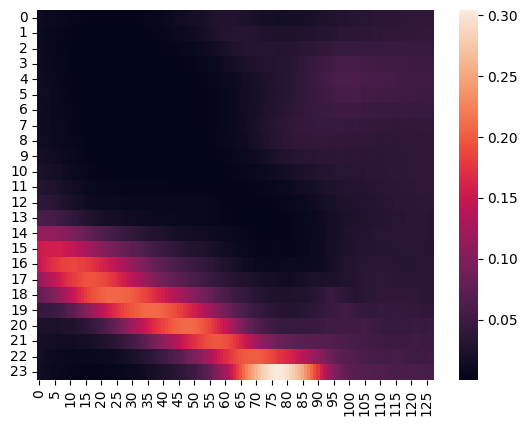

In [304]:
import seaborn as sns

sns.heatmap(attn_pred_all.mean(dim=0).T.cpu().numpy(), cbar=True)

## Evaluation

In [305]:
from torchmetrics.functional import pearson_corrcoef

correlations_time = np.zeros((y_pred_all.shape[0], y_pred_all.shape[2]))
for sample in tqdm(range(y_pred_all.shape[0])):
    y_pred_sample = y_pred_all[sample, :, :]
    y_true_sample = y_true_all[sample, :, :]
    for tp in range(y_pred_all.shape[2]):
        pred = y_pred_sample[:, tp]
        target = y_true_sample[:, tp]
        corr = pearson_corrcoef(pred.cpu(), target)
        correlations_time[sample, tp] = corr.item()

100%|██████████| 513/513 [00:07<00:00, 65.21it/s]


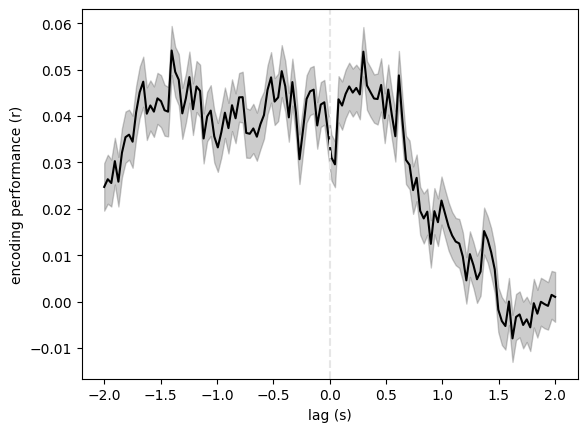

In [306]:
from matplotlib import pyplot as plt

n_array = 100

lags = np.linspace(-pre_stimulus, tmax, brain_timep) 
# value_array = y_pred_all[:,n_array,:].mean((0))
mean = correlations_time.mean((0))
std = correlations_time.std((0)) / np.sqrt(np.product(correlations_time.shape[:1]))

fig, ax = plt.subplots()
ax.plot(lags, mean, color='black')
ax.fill_between(lags, mean - std, mean + std, alpha=0.2, color='black')
ax.set_xlabel("lag (s)")
ax.set_ylabel("encoding performance (r)")
ax.axvline(0, c=(.9, .9, .9), ls="--")
# ax.axhline(0, c=(.9, .9, .9), ls="--")
fig.show()

In [307]:
from torchmetrics.functional import pearson_corrcoef

correlations_channels = np.zeros((y_pred_all.shape[0], y_pred_all.shape[1]))
for sample in tqdm(range(y_pred_all.shape[0])):
    y_pred_sample = y_pred_all[sample, :, :]
    y_true_sample = y_true_all[sample, :, :]
    for channel in range(y_pred_all.shape[1]):
        pred = y_pred_sample[channel, :]
        target = y_true_sample[channel, :]
        corr = pearson_corrcoef(pred.cpu(), target)
        correlations_channels[sample, channel] = corr.item()

100%|██████████| 513/513 [00:08<00:00, 61.64it/s]


In [308]:
correlations_channels_mean = np.mean(correlations_channels, axis=0)

Coordinate matrix shape:  (166, 3)


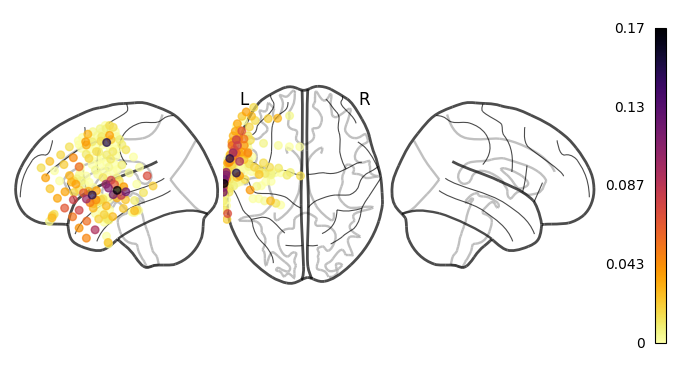

In [309]:
from nilearn.plotting import plot_markers

raw = mne.io.read_raw_fif(file_path, verbose=False)
raw.load_data(verbose=False)
raw = raw.apply_function(func, channel_wise=False, verbose=False)

ch2loc = {ch['ch_name']: ch['loc'][:3] for ch in raw.info['chs']}
coords = np.vstack([ch2loc[ch] for ch in raw.info['ch_names']])
coords *= 1000  # nilearn likes to plot in meters, not mm
print("Coordinate matrix shape: ", coords.shape)

order = correlations_channels_mean.argsort()
plot_markers(correlations_channels_mean[order], coords[order],
             node_size=30, display_mode='lzr',
             node_vmin=0, node_cmap='inferno_r', colorbar=True)
plt.show()